# Bayesian seats model: Estimating seats from election outcome

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Supporting-functions" data-toc-modified-id="Supporting-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Supporting functions</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Stan-2pp-difference-to-seats-difference-conversion-model" data-toc-modified-id="Stan-2pp-difference-to-seats-difference-conversion-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Stan 2pp-difference to seats-difference conversion model</a></span><ul class="toc-item"><li><span><a href="#Estimate-with-Stan" data-toc-modified-id="Estimate-with-Stan-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Estimate with Stan</a></span></li><li><span><a href="#Cross-check-with-statsmodels" data-toc-modified-id="Cross-check-with-statsmodels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cross check with statsmodels</a></span></li></ul></li><li><span><a href="#Save-results" data-toc-modified-id="Save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save results</a></span></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1 MBP
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# system imports
import pathlib
import math

# local imports
import common
from common import COLOR_COALITION, COLOR_LABOR, COLOR_OTHER

In [2]:
# enable pystan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

In [4]:
# data locations
SEAT_HISTORY_FILE = '../historical-data/Seat History.csv'

## Supporting functions

## Get the data

Note: the data was produced by the "capture wiki election history data and preliminary charts" notebook.

In [5]:
def fix_column_names(t: pd.DataFrame) -> pd.DataFrame:
    """Replace 'Unnamed' column names with ''."""
    
    replacements = {}
    for c in t.columns:
        if 'Unnamed' in c[1]:
            replacements[c[1]] = ''
    if replacements:
        t = t.rename(columns=replacements, level=1)
    return t

In [6]:
# Load historical elections data
seat_history = pd.read_csv(SEAT_HISTORY_FILE, header=[0, 1], 
                           index_col=0, parse_dates=[0], )
seat_history = fix_column_names(seat_history)
seat_history.index.dtype

dtype('<M8[ns]')

In [7]:
seat_history.columns

MultiIndex([(               'Primary vote',   'ALP'),
            (               'Primary vote',  'L+NP'),
            (               'Primary vote',  'Oth.'),
            (                   '2PP vote',   'ALP'),
            (                   '2PP vote',  'L+NP'),
            (                      'Seats',   'ALP'),
            (                      'Seats',  'L+NP'),
            (                      'Seats',  'Oth.'),
            (                      'Seats', 'Total'),
            ('Governing party at election',      ''),
            (            'Governing since',      ''),
            (             'PM at election',      ''),
            (              'Winning party',      ''),
            (                      'Notes',      ''),
            (             'log gov period',      ''),
            (                     'winner',      ''),
            (      'Govt 2pp votes margin',      ''),
            (          'Govt seats margin',      '')],
           )

In [8]:
seat_history['Proportion of others'] = (
    seat_history[('Seats',  'Oth.')] 
    / seat_history[('Seats', 'Total')]
)

In [9]:
# limit input data to recent history
HISTORY_START = 1969 # let's start with Don's party ...
seat_history = seat_history[seat_history.index.year >= HISTORY_START]

In [10]:
# limit autoregressive model of non-major party members to an even more recent period
seat_history['Row number'] = range(1, len(seat_history)+1)
AUTOREGRESS_FROM = 1993 # previous election non-zero, also subsequent also non-zero
assert(AUTOREGRESS_FROM >= HISTORY_START)
ar_from = seat_history.loc[seat_history.index.year == AUTOREGRESS_FROM, 'Row number'].values[0]
ar_from

11

In [11]:
len(seat_history)

20

## Stan 2pp-difference to seats-difference conversion model

### Estimate with Stan

In [12]:
conversion_data = {
    'n_history': len(seat_history),
    'seats': seat_history['Govt seats margin'].values,
    'votes': seat_history['Govt 2pp votes margin'].values,
}

In [13]:
conversion_model = """
data {
    int<lower=1> n_history;    // length of election history
    vector<lower=-1,upper=1>[n_history] seats;  // Coalition seats margin (response)
    vector<lower=-1,upper=1>[n_history] votes;  // Coalition votes margin (inputs)
}

parameters {
    // historical relationship between 2pp votes and seats
    real slope;
    real intercept;
    real<lower=0.000001> sigma; // force half cauchy with lower bound  
}

model {
    // priors on vote difference
    intercept ~ normal(0, 1);
    slope ~ normal(3, 1);      
    sigma ~ cauchy(0, 1);

    // linear regression from 2pp vote difference to seats difference
    // use student_t here for the fatter tails ...
    seats ~ student_t(5, intercept + (slope * votes), sigma); // fatter tails
    //seats ~ normal(intercept + (slope * votes), sigma); // normal dist.   
}

generated quantities {

    // --- MODEL DIAGNOSTICS ---
    
    // 2pp to seats relationship
    vector<lower=-1,upper=1>[n_history] seats_estimate;
    seats_estimate = slope * votes + intercept;
    
    // prediction interval on 2pp to seats relationship
    real<lower=-1,upper=1> predict_interval[n_history] = 
        normal_rng(intercept + (slope * votes), sigma);
}
"""

In [14]:
conv_posterior = stan.build(conversion_model, data=conversion_data)

# Note: Stan typically produces an ocean of compiler warnings.
#       For the most part these are utterly _useless_ warnings.
#       But there may be an important parser diagnostic that 
#       requres action buried among the blathering. Searching
#.      for "PARSER" and "DIAGNOSTIC" can help find if there is 
#.      something of concern.
#       https://mc-stan.org/misc/warnings.html#compiler-warnings

Building: found in cache, done.


In [15]:
conv_fit = conv_posterior.sample(num_chains=4, num_samples=25_000)

# Very occasionally generates an "inifity should be positive
# finite" Exception. These seem to be well managed. 
# They typically occur at less than one per 100,000 samples.

Sampling:   0%
Sampling:  25% (26000/104000)
Sampling:  50% (52000/104000)
Sampling:  75% (78000/104000)
Sampling: 100% (104000/104000)
Sampling: 100% (104000/104000), done.
Messages received during sampling:
  Gradient evaluation took 2.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.22 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!


In [16]:
az.summary(conv_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,3.354,0.312,2.762,3.943,0.001,0.001,77458.0,64249.0,1.0
intercept,0.036,0.017,0.004,0.068,0.000,0.000,79300.0,67674.0,1.0
sigma,0.065,0.014,0.041,0.091,0.000,0.000,75128.0,67122.0,1.0
seats_estimate[0],0.022,0.017,-0.010,0.055,0.000,0.000,77992.0,67386.0,1.0
seats_estimate[1],-0.146,0.026,-0.194,-0.096,0.000,0.000,71048.0,63254.0,1.0
seats_estimate[2],0.150,0.019,0.114,0.185,0.000,0.000,89931.0,67934.0,1.0
seats_estimate[3],0.418,0.037,0.347,0.487,0.000,0.000,87396.0,65762.0,1.0
seats_estimate[4],0.344,0.031,0.284,0.402,0.000,0.000,88996.0,66052.0,1.0
seats_estimate[5],0.062,0.017,0.032,0.095,0.000,0.000,82169.0,67734.0,1.0
seats_estimate[6],-0.179,0.028,-0.233,-0.126,0.000,0.000,70959.0,62726.0,1.0


array([[<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

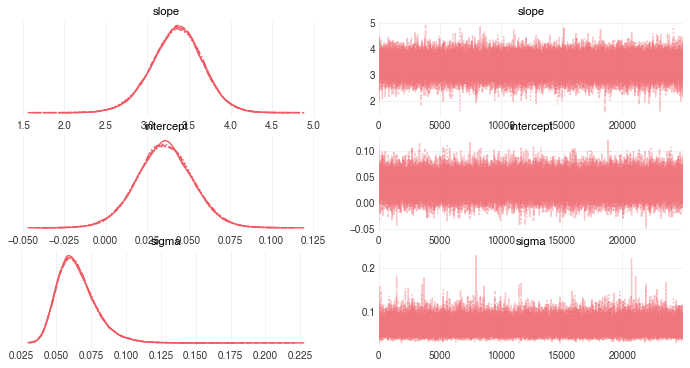

In [17]:
az.plot_trace(conv_fit, var_names=['slope', 'intercept', 'sigma',])

In [18]:
conv_results_df = conv_fit.to_frame()

In [19]:
# check there are no nans 
key_factors = ['slope', 'intercept', 'sigma']
conv_results_df[key_factors].isna().sum()

parameters
slope        0
intercept    0
sigma        0
dtype: int64

In [20]:
key_results = conv_results_df[key_factors].mode().T[0] # note: sigma is skewed
key_results

parameters
slope        3.204033
intercept    0.026610
sigma        0.046472
Name: 0, dtype: float64

In [21]:
# just out of curiosity ...
key_results = conv_results_df[key_factors].median() 
key_results

parameters
slope        3.360653
intercept    0.035437
sigma        0.062810
dtype: float64

In [22]:
conv_slope, conv_intercept, conv_sigma = key_results.to_list()
equation = f'y = {conv_slope:.5f}x + {conv_intercept:.5f};  σ={conv_sigma:.5f}' 
equation

'y = 3.36065x + 0.03544;  σ=0.06281'

In [23]:
quants = [0.005, 0.025, 0.100, 0.250, 0.500, 0.750, 0.900, 0.975, 0.995]
LOW, HIGH = 'low', 'high'
ranges = pd.DataFrame({
    '99%': (0.005, 0.995),
    '95%': (0.025, 0.975),
    '80%': (0.100, 0.900),
    '50%': (0.250, 0.750),
}, index=[LOW, HIGH]).T
ranges

,low,high
99%,0.005,0.995
95%,0.025,0.975
80%,0.100,0.900
50%,0.250,0.750


In [24]:
def get_estimates_quants(pattern):

    # Get seat estimate quantiles
    seat_estimate = (
        conv_results_df[conv_results_df.columns[
            conv_results_df.columns.str.contains(pattern)
        ]]
    )
    seat_estimate.columns = seat_history.index
    seat_estimate = seat_estimate.quantile(quants).T

    # link to votes
    seat_estimate['2pp votes'] = seat_history['Govt 2pp votes margin']
    seat_estimate = seat_estimate.sort_values('2pp votes')
    
    return seat_estimate
        
estimates = get_estimates_quants('seats_estimate')

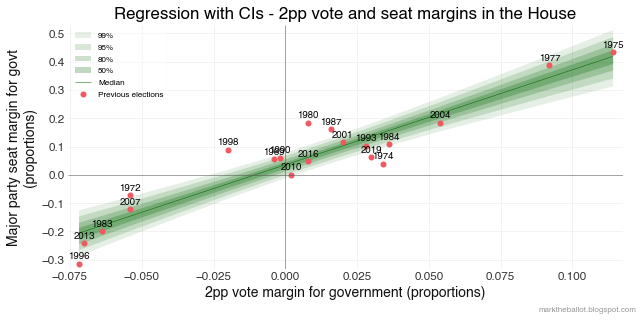

In [25]:
def plot_est_quants(estimates, title, **kwargs):
    # plot this relationship
    fig, ax = common.initiate_plot()
    alpha = 0.1
    for x, y in ranges.iterrows():
        low = y[0]
        high = y[1]
        lowpoint = estimates[low]
        highpoint = estimates[high]
        ax.fill_between(x=estimates['2pp votes'], y1=lowpoint, y2=highpoint,
                    color='darkgreen', alpha = alpha, label=x,)
        alpha += 0.05
    
    ax.plot(estimates['2pp votes'], estimates[0.500], 
        color='darkgreen', lw=0.5, label='Median')

    ax.scatter(seat_history['Govt 2pp votes margin'],
               seat_history['Govt seats margin'],
               label='Previous elections')

    ax.axhline(0, lw=0.5, color='#555555')
    ax.axvline(0, lw=0.5, color='#555555')

    for x, y, s in zip(seat_history['Govt 2pp votes margin'],
                       seat_history['Govt seats margin']+0.01,
                       seat_history.index.year.astype(str)):
        ax.text(x, y, s, fontsize='x-small', va='bottom', ha='center')
    

    ax.legend(loc='best')
    common.plot_finalise(ax, 
                  title=title,
                  xlabel='2pp vote margin for government (proportions)', 
                  ylabel='Major party seat margin for govt\n(proportions)',
                  **kwargs)

plot_est_quants(estimates, 
                'Regression with CIs - 2pp vote and seat margins in the House')

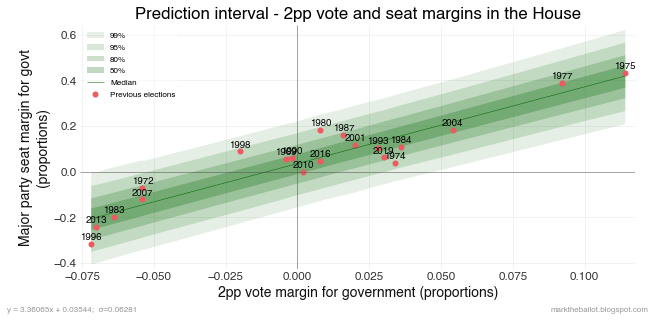

In [26]:
predictions = get_estimates_quants('predict_interval')
plot_est_quants(predictions, 
                'Prediction interval - 2pp vote and seat margins in the House',
                lfooter=equation)

### Cross check with statsmodels

In [27]:
# ordinary least squares regression model
data = seat_history[['Govt seats margin', 
                     'Govt 2pp votes margin']].sort_values('Govt 2pp votes margin')
y = data['Govt seats margin'].values
x = data['Govt 2pp votes margin'].values
x_const = sm.add_constant(x) 
fitted = sm.OLS(y, x_const).fit() 
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     123.3
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           1.74e-09
Time:                        14:31:40   Log-Likelihood:                 26.519
No. Observations:                  20   AIC:                            -49.04
Df Residuals:                      18   BIC:                            -47.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0369      0.015      2.421      0.026       0.005       0.069
x1             3.3900      0.305     11.103      0.000       2.749       4.031
==============================================================================
Omnibus:                        0.208   Durbin-Watson:                   0.958
Prob(Omnibus):                  0.901   Jarque-Bera (JB):                0.392
Skew:                           0.160   Prob(JB):                        0.822
Kurtosis:                       2.393   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# get the prediction interval
pred_std_error, lower_pred, upper_pred = wls_prediction_std(fitted, exog=x_const)
pred_std_error.min(), pred_std_error.mean(), pred_std_error.max()

(0.06940842230698828, 0.07100696443153251, 0.07695599456892749)

## Save results

In [29]:
key_results.to_csv('../historical-data/election-to-seats-outcome.csv')